In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

def get_preprocessed_stock(ticker: str, start="2020-01-01", end=None):
    """
    下載並清理股票資料，輸出統一格式：
    ['Date', 'Close', 'High', 'Low', 'Open', 'Volume',
     'date_weekday', 'netChangeRatio', 'positive', 'ATR14', 'ATR21']
    """
    # 1️⃣ 下載資料
    df = yf.download(ticker, start=start, end=end, group_by='ticker', auto_adjust=False)

    # 若為 MultiIndex（多層欄位，例如 ('TSLA','Close')）
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(0)

    # 保留主要欄位並重設索引
    df = df[['Close', 'High', 'Low', 'Open', 'Volume']].dropna().copy()
    df = df.reset_index()

    # 2️⃣ 日期資訊
    df['date_weekday'] = df['Date'].dt.weekday  # 0=Mon, ..., 6=Sun

    # 3️⃣ 計算漲跌幅（netChangeRatio）
    df['preClose'] = df['Close'].shift(1)
    df['netChangeRatio'] = (df['Close'] - df['preClose']) / df['preClose'] * 100

    # 4️⃣ 是否上漲（1=漲，0=跌或持平）
    df['positive'] = (df['netChangeRatio'] > 0).astype(int)

    # 5️⃣ 計算 ATR14 / ATR21
    # True Range (TR)：最大值於 [High-Low, |High-preClose|, |Low-preClose|]
    high_low = df['High'] - df['Low']
    high_close = (df['High'] - df['preClose']).abs()
    low_close = (df['Low'] - df['preClose']).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    df['ATR14'] = tr.rolling(window=14).mean()
    df['ATR21'] = tr.rolling(window=21).mean()

    # 6️⃣ 整理欄位順序
    df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume',
             'date_weekday', 'netChangeRatio', 'positive', 'ATR14', 'ATR21']]

    # 第一筆 NaN 改為 0，方便模型或分析使用
    df = df.fillna(0)

    return df


# 🔍 範例：抓取 Tesla (TSLA)
tsla_df = get_preprocessed_stock("TSLA", start="2015-01-01", end="2016-12-31")
tsla_df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive,ATR14,ATR21
499,2016-12-23,14.222667,14.230000,13.847333,13.866667,70057500,4,2.345888,1,0.338143,0.356286
500,2016-12-27,14.635333,14.816667,14.294667,14.325333,88735500,1,2.901469,1,0.360952,0.371556
501,2016-12-28,14.649333,14.920000,14.480000,14.768667,56737500,2,0.095658,1,0.352381,0.377270
502,2016-12-29,14.312000,14.613333,14.274667,14.570667,60675000,3,-2.302717,0,0.361952,0.372159
503,2016-12-30,14.246000,14.500000,14.112000,14.420000,69639000,4,-0.461151,0,0.375238,0.376698


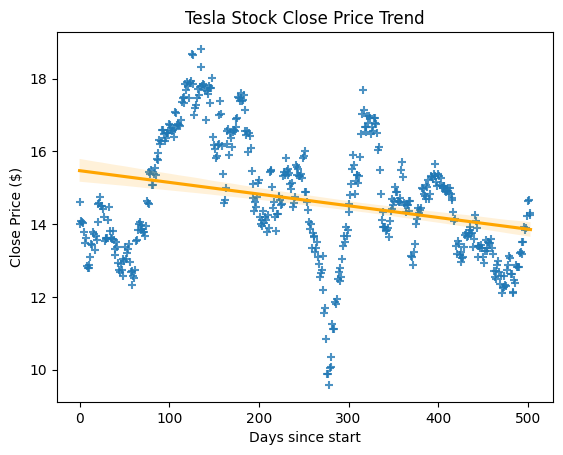

In [2]:
# 用seaborn找出趨勢
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_context(rc={'figure.figsize': (14, 7)})

sns.regplot(
    x=np.arange(0, tsla_df.shape[0]),
    y=tsla_df['Close'].values,
    marker='+',
    line_kws={'color': 'orange'}  # 改成橘色線會更醒目
)

plt.title("Tesla Stock Close Price Trend")
plt.xlabel("Days since start")
plt.ylabel("Close Price ($)")
plt.show()

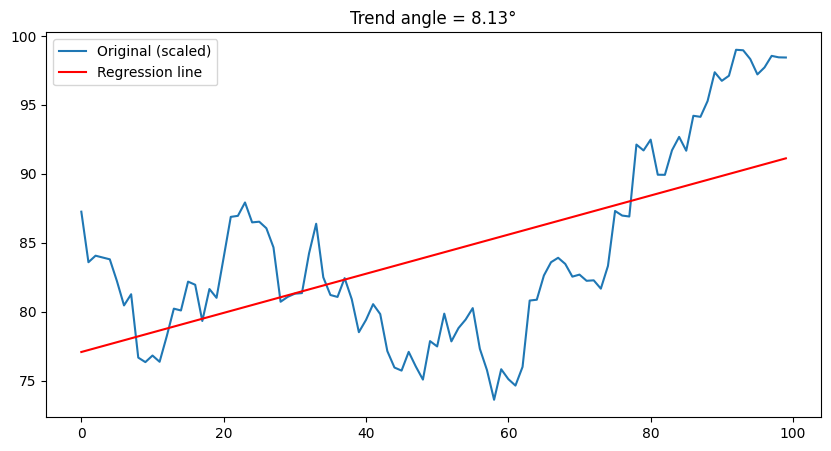

8.133848403482077


In [3]:
# 有時候需要計算趨勢的角度

import statsmodels.api as sm
from statsmodels import regression

def calc_regress_deg(y_arr, show=True):
    """
    根據輸入的 y 序列（例如股價），計算回歸趨勢的角度。

    計算邏輯：
        1️⃣ 用 OLS 線性回歸擬合 y = kx + b
        2️⃣ 取出斜率 k
        3️⃣ 將斜率轉換成角度（degree）

    參數：
        y_arr : list 或 np.array
            要分析的數據（如股價序列）
        show : bool
            是否畫出回歸線與角度標題（預設 True）

    回傳：
        float — 趨勢角度（單位：度）
    """
    # x 軸：0, 1, 2, ..., len(y_arr)
    x = np.arange(0, len(y_arr))

    # 將 y 縮放到與 x 同級別（避免數值差異過大影響回歸）
    zoom_factor = x.max() / y_arr.max()
    y_scaled = y_arr * zoom_factor

    # statsmodels 的 OLS 需要手動加常數項
    x_const = sm.add_constant(x)

    # 建立回歸模型
    model = regression.linear_model.OLS(y_scaled, x_const).fit()

    # y = kx + b → params[1] 是斜率
    slope = model.params[1]

    # 將斜率（弧度）轉換成角度
    deg = np.rad2deg(slope)

    if show:
        intercept = model.params[0]
        reg_y_fit = intercept + slope * x
        plt.figure(figsize=(10, 5))
        plt.plot(x, y_scaled, label='Original (scaled)')
        plt.plot(x, reg_y_fit, color='red', label='Regression line')
        plt.title(f"Trend angle = {deg:.2f}°")
        plt.legend()
        plt.show()

    return deg

print(calc_regress_deg(tsla_df['Close'][:100].values))


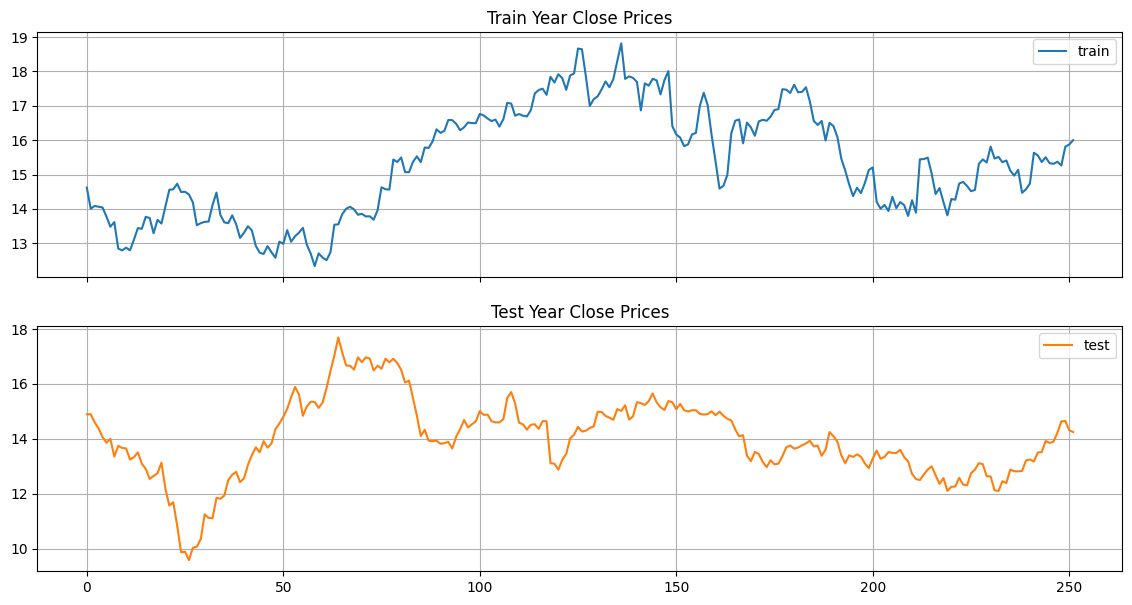

In [4]:
# 範例1 - 均值回復策略
kl_pd = tsla_df.copy()

# 取前一年（252 個交易日）作為訓練資料
train_kl = kl_pd[:252]
# 後一年（252 之後）作為測試資料
test_kl = kl_pd[252:]

# 建立 DataFrame 用來畫圖
tmp_df = pd.DataFrame({
    'train': train_kl['Close'].values,
    'test': test_kl['Close'].values
})

# 畫圖（上下兩張圖分別顯示訓練與測試階段）
tmp_df[['train', 'test']].plot(
    subplots=True, grid=True, figsize=(14, 7),
    title=['Train Year Close Prices', 'Test Year Close Prices']
)
plt.show()

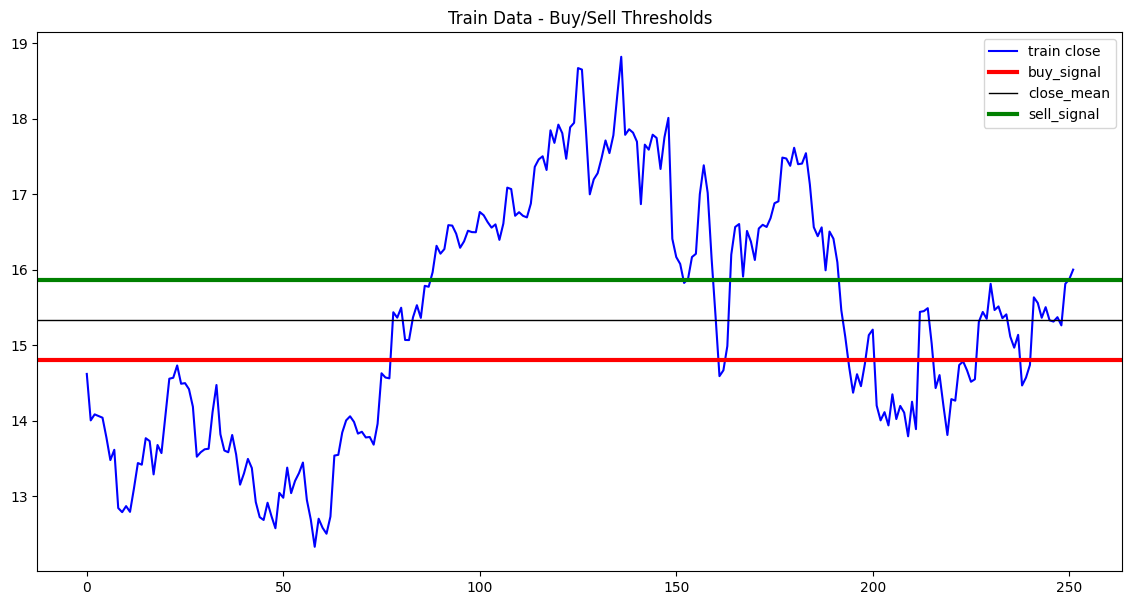

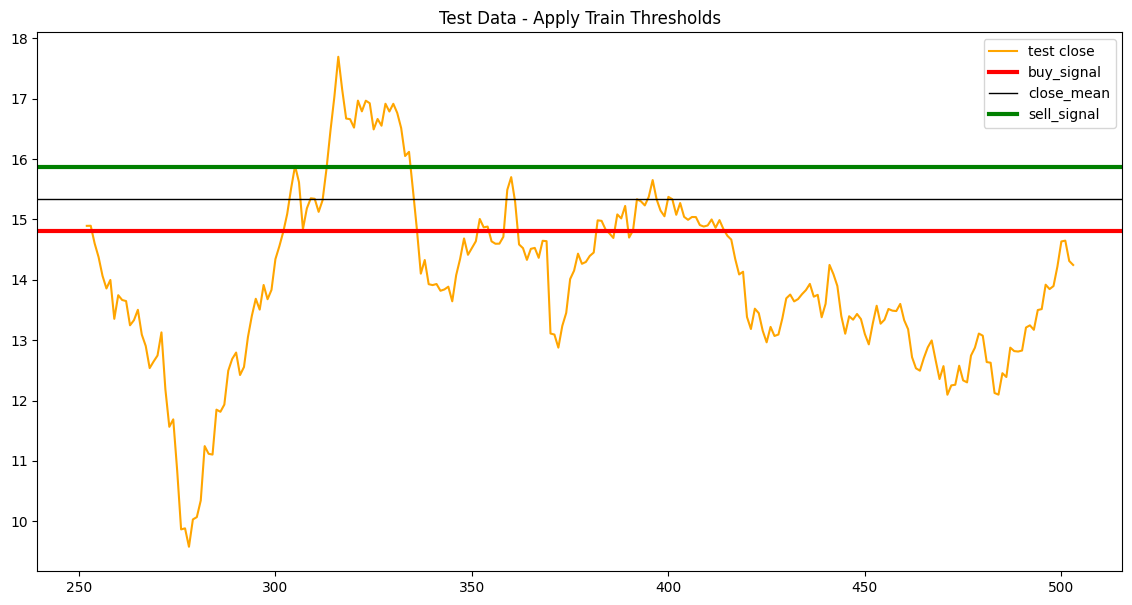

📉 買入信號門檻：14.81
📈 賣出信號門檻：15.86


In [5]:
# ------------------------------------------------
# 📊 訓練集：計算平均、標準差、買賣信號
# ------------------------------------------------
close_mean = train_kl["Close"].mean()  # 收盤價平均
close_std = train_kl["Close"].std()    # 收盤價標準差

# 訊號設定：以 ±(1/3 標準差) 作為買入與賣出門檻
buy_signal = close_mean - close_std / 3
sell_signal = close_mean + close_std / 3

# ------------------------------------------------
# 📈 視覺化：訓練資料信號
# ------------------------------------------------
plt.figure(figsize=(14, 7))
train_kl["Close"].plot(label="train close", color="blue")

# 劃出買賣線
plt.axhline(buy_signal, color='r', lw=3, label='buy_signal')
plt.axhline(close_mean, color='black', lw=1, label='close_mean')
plt.axhline(sell_signal, color='g', lw=3, label='sell_signal')

plt.legend(loc='best')
plt.title("Train Data - Buy/Sell Thresholds")
plt.show()

# ------------------------------------------------
# 📈 視覺化：測試資料信號（套用訓練集的門檻）
# ------------------------------------------------
plt.figure(figsize=(14, 7))
test_kl["Close"].plot(label="test close", color="orange")

plt.axhline(buy_signal, color='r', lw=3, label='buy_signal')
plt.axhline(close_mean, color='black', lw=1, label='close_mean')
plt.axhline(sell_signal, color='g', lw=3, label='sell_signal')

plt.legend(loc='best')
plt.title("Test Data - Apply Train Thresholds")
plt.show()

print(f"📉 買入信號門檻：{buy_signal:.2f}")
print(f"📈 賣出信號門檻：{sell_signal:.2f}")

In [13]:
# 透過訊號來買入賣出
# 建立買入訊號(1)
buy_index = test_kl[test_kl['Close'] <=  buy_signal].index
test_kl.loc[buy_index, 'signal'] = 1

# 建立賣出訊號(0)
sell_index = test_kl.loc[test_kl['Close'] >= sell_signal].index
test_kl.loc[sell_index, 'signal'] = 0

# 看看買入賣出訊號
# print(test_kl[test_kl['signal'] == 1].tail(3))
# print(test_kl[test_kl['signal'] == 0].tail(3))


# 目前假設全倉操作，所以 signal = keep,即1代表買入持有，0代表賣出空倉
test_kl['keep'] = test_kl['signal']
# 將keep中的NAN填充，讓keep可以代表最終的交易持股狀態
test_kl['keep'] = test_kl['keep'].ffill()

test_kl.tail(3)


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_61937/3274664436.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kl['keep'] = test_kl['signal']
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_61937/3274664436.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kl['keep'] = test_kl['keep'].ffill()


Price,Date,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive,ATR14,ATR21,signal,keep
501,2016-12-28,14.649333,14.920000,14.480000,14.768667,56737500,2,0.095658,1,0.352381,0.377270,1.0,1.0
502,2016-12-29,14.312000,14.613333,14.274667,14.570667,60675000,3,-2.302717,0,0.361952,0.372159,1.0,1.0
503,2016-12-30,14.246000,14.500000,14.112000,14.420000,69639000,4,-0.461151,0,0.375238,0.376698,1.0,1.0


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_61937/1829020506.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kl['benchmark_profit'] = np.log(test_kl['Close'] / test_kl['Close'].shift(1))
/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_61937/1829020506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kl['benchmark_profit2'] = test_kl['Close'] / test_kl['Close'].shift(1) - 1


Price  benchmark_profit  benchmark_profit2
252                 NaN                NaN
253            0.000090           0.000090
254           -0.019844          -0.019648


array([<Axes: >, <Axes: >], dtype=object)

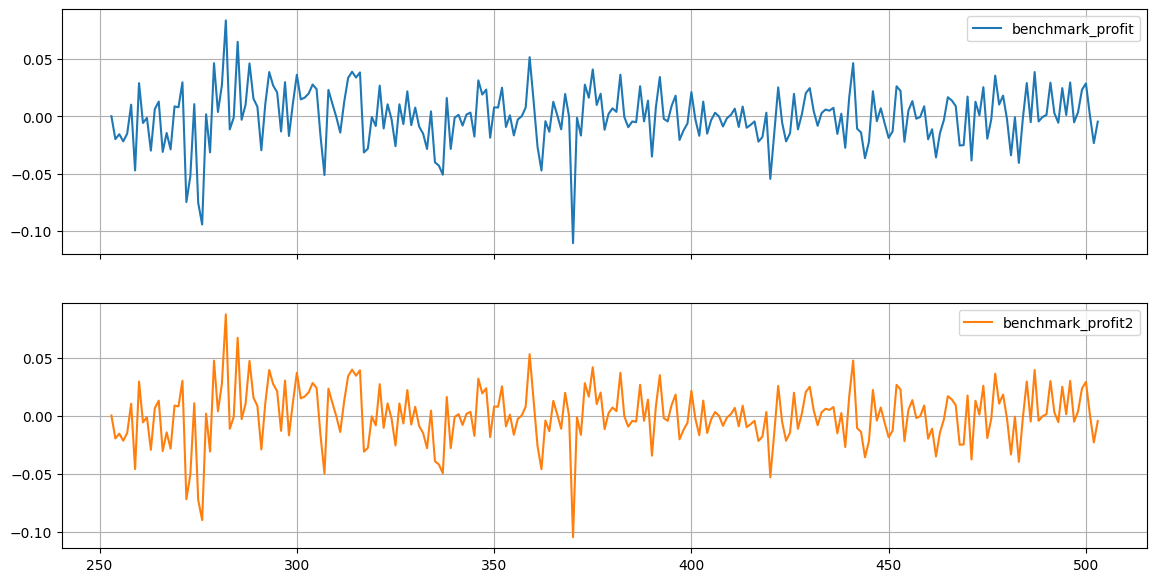

In [ ]:
# 計算以下：
# 1. 基準收益
# 2. 使用均值回復策略的收益
# 3. 可視化收益對比

# 用對數報酬率計算每日報酬（連續報酬率）
test_kl['benchmark_profit'] = np.log(test_kl['Close'] / test_kl['Close'].shift(1))

# 用一般百分比報酬計算（離散報酬率）
test_kl['benchmark_profit2'] = test_kl['Close'] / test_kl['Close'].shift(1) - 1

print(test_kl[['benchmark_profit', 'benchmark_profit2']].head(3))

# 視覺化比較一下指數報酬率(ln(p2/p1))與離散報酬率(p2/p1-1)
test_kl[['benchmark_profit', 'benchmark_profit2']].plot(
    subplots=True, grid=True, figsize=(14, 7)
)

# 

| 特性    | 離散報酬率（Simple）             | 對數報酬率（Log）         |
| ----- | ------------------------- | ------------------ |
| 計算方式  | (\frac{P_t}{P_{t-1}} - 1) | (\ln(P_t/P_{t-1})) |
| 多日合併  | ❌ 不能相加（須相乘）               | ✔ 可以直接相加           |
| 是否對稱  | ❌ -50% ≠ +50%             | ✔ log 平滑且較對稱       |
| 是否直覺  | ✔ 是百分比                    | ❌ 不易理解             |
| 統計建模  | 較少使用                      | ⭐ 標準做法             |
| 小幅波動時 | 與 log return 幾乎相同         | 與離散幾乎相同            |


/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_61937/1540438835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kl['trend_profit'] = test_kl['keep'] * test_kl['benchmark_profit']


<Axes: >

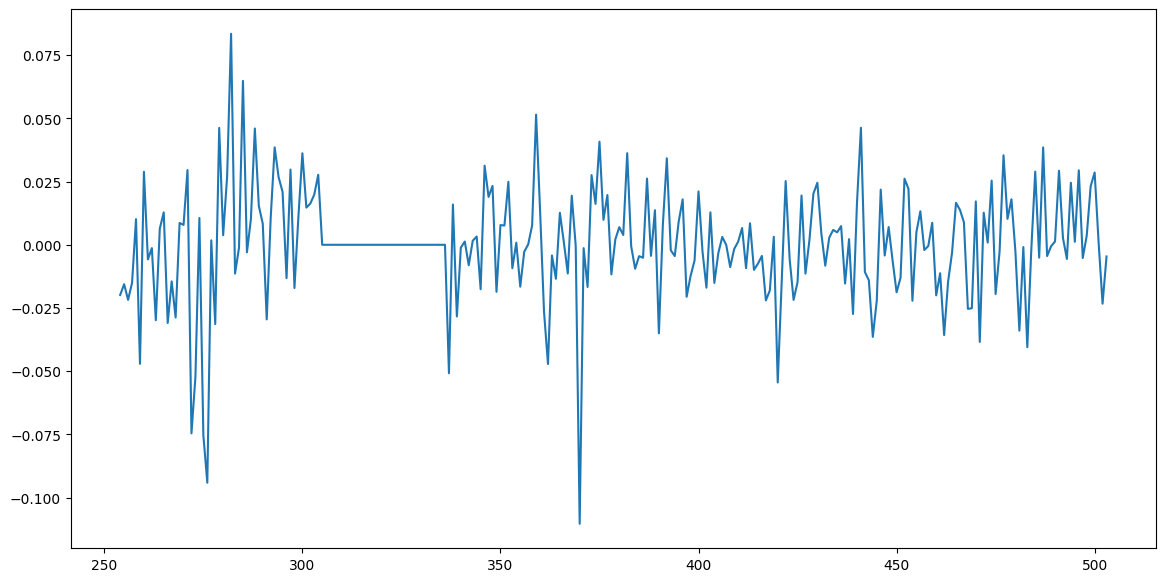

In [20]:
test_kl['trend_profit'] = test_kl['keep'] * test_kl['benchmark_profit']
test_kl['trend_profit'].plot(figsize=(14, 7))

<Axes: >

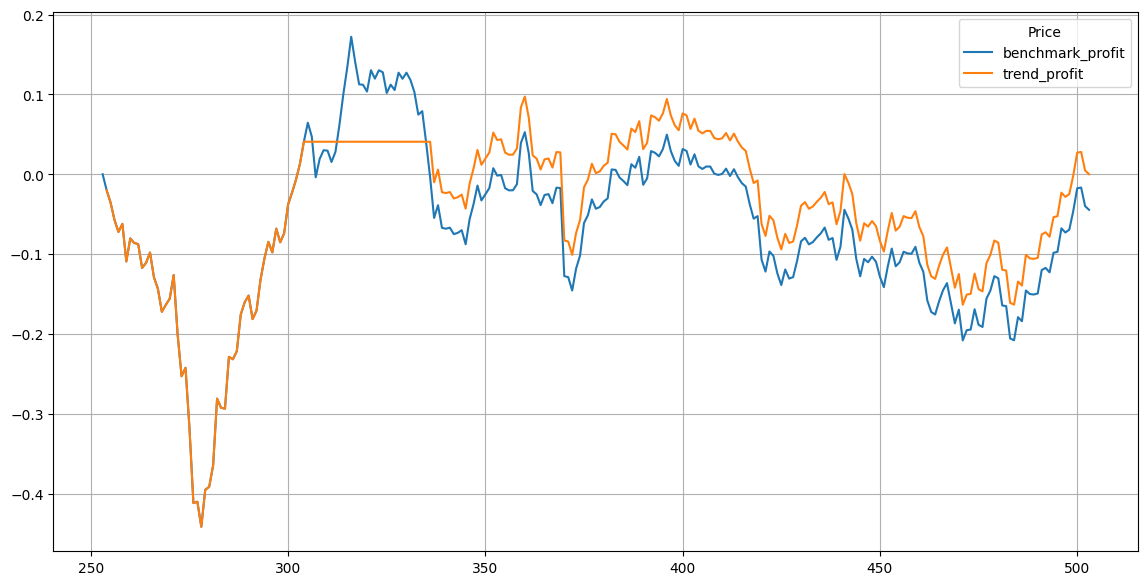

In [21]:
test_kl[['benchmark_profit', 'trend_profit']].cumsum().plot(
    grid=True, figsize=(14, 7)
)